## Simulations
In this notebook, we run THOR on a simulated survey of 16 fields. Each field is visited once every other night over 14 nights resulting in 7 unique visits per field. A MOPS-type algorithm requiring nightly revisits would find none of the objects in this survey.

Data and results files for this notebook may be downloaded [here](https://dirac.astro.washington.edu/~moeyensj/projects/thor/paper1/).

In [1]:
%load_ext autoreload
%autoreload 2

import glob
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(font_scale=1.2, context="paper", style="ticks")
sns.set_palette("viridis")

%matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

In [2]:
import thor

from thor import __version__
print("THOR version: {}".format(__version__))

import difi

from difi import __version__
print("difi version: {}".format(__version__))

THOR version: 1.1.dev199+g1c54766.d20210401
difi version: 1.1.dev57+gf3bff13.d20210323


In [3]:
DATABASE = "/home/moeyensj/projects/thor/thor_data/msst_4x4/msst_survey.db"
con = sql.connect(DATABASE)

# Load Data

In [4]:
observations_noNoise = pd.read_sql("""SELECT * FROM observations WHERE night < 59754""", con)
print(len(observations_noNoise))
observations_noNoise.drop_duplicates(subset=["designation", "exp_mjd"], inplace=True)
print(len(observations_noNoise))
noise = pd.read_sql("""SELECT * FROM noise_100 WHERE night < 59754""", con)
noise["obsId"] = np.arange(observations_noNoise["obsId"].values[-1] + 1, observations_noNoise["obsId"].values[-1] + 1 + len(noise))

2315689
2313850


In [5]:
observations = pd.concat([observations_noNoise, noise], sort=False)
observations.reset_index(inplace=True, drop=True)
del observations_noNoise
del noise

In [6]:
survey = pd.read_sql("""SELECT * FROM survey""", con)

In [7]:
orbits = pd.read_sql("""SELECT * FROM mpcOrbitCat""", con)
# Only grab the orbits of objects with observations
orbits = orbits[orbits["designation"].isin(observations["designation"].unique())]
orbits.drop_duplicates(subset=["designation"], inplace=True)

In [8]:
np.random.seed(42)

rand_error = 0.1/3600
ra_error = np.random.normal(loc=0, scale=rand_error, size=len(observations)) / np.cos(np.radians(observations["Dec_deg"].values))
dec_error = np.random.normal(loc=0, scale=rand_error, size=len(observations))

observations.loc[:, "RA_deg"] += ra_error
observations.loc[:, "Dec_deg"] += dec_error

(140.0, 200.0)

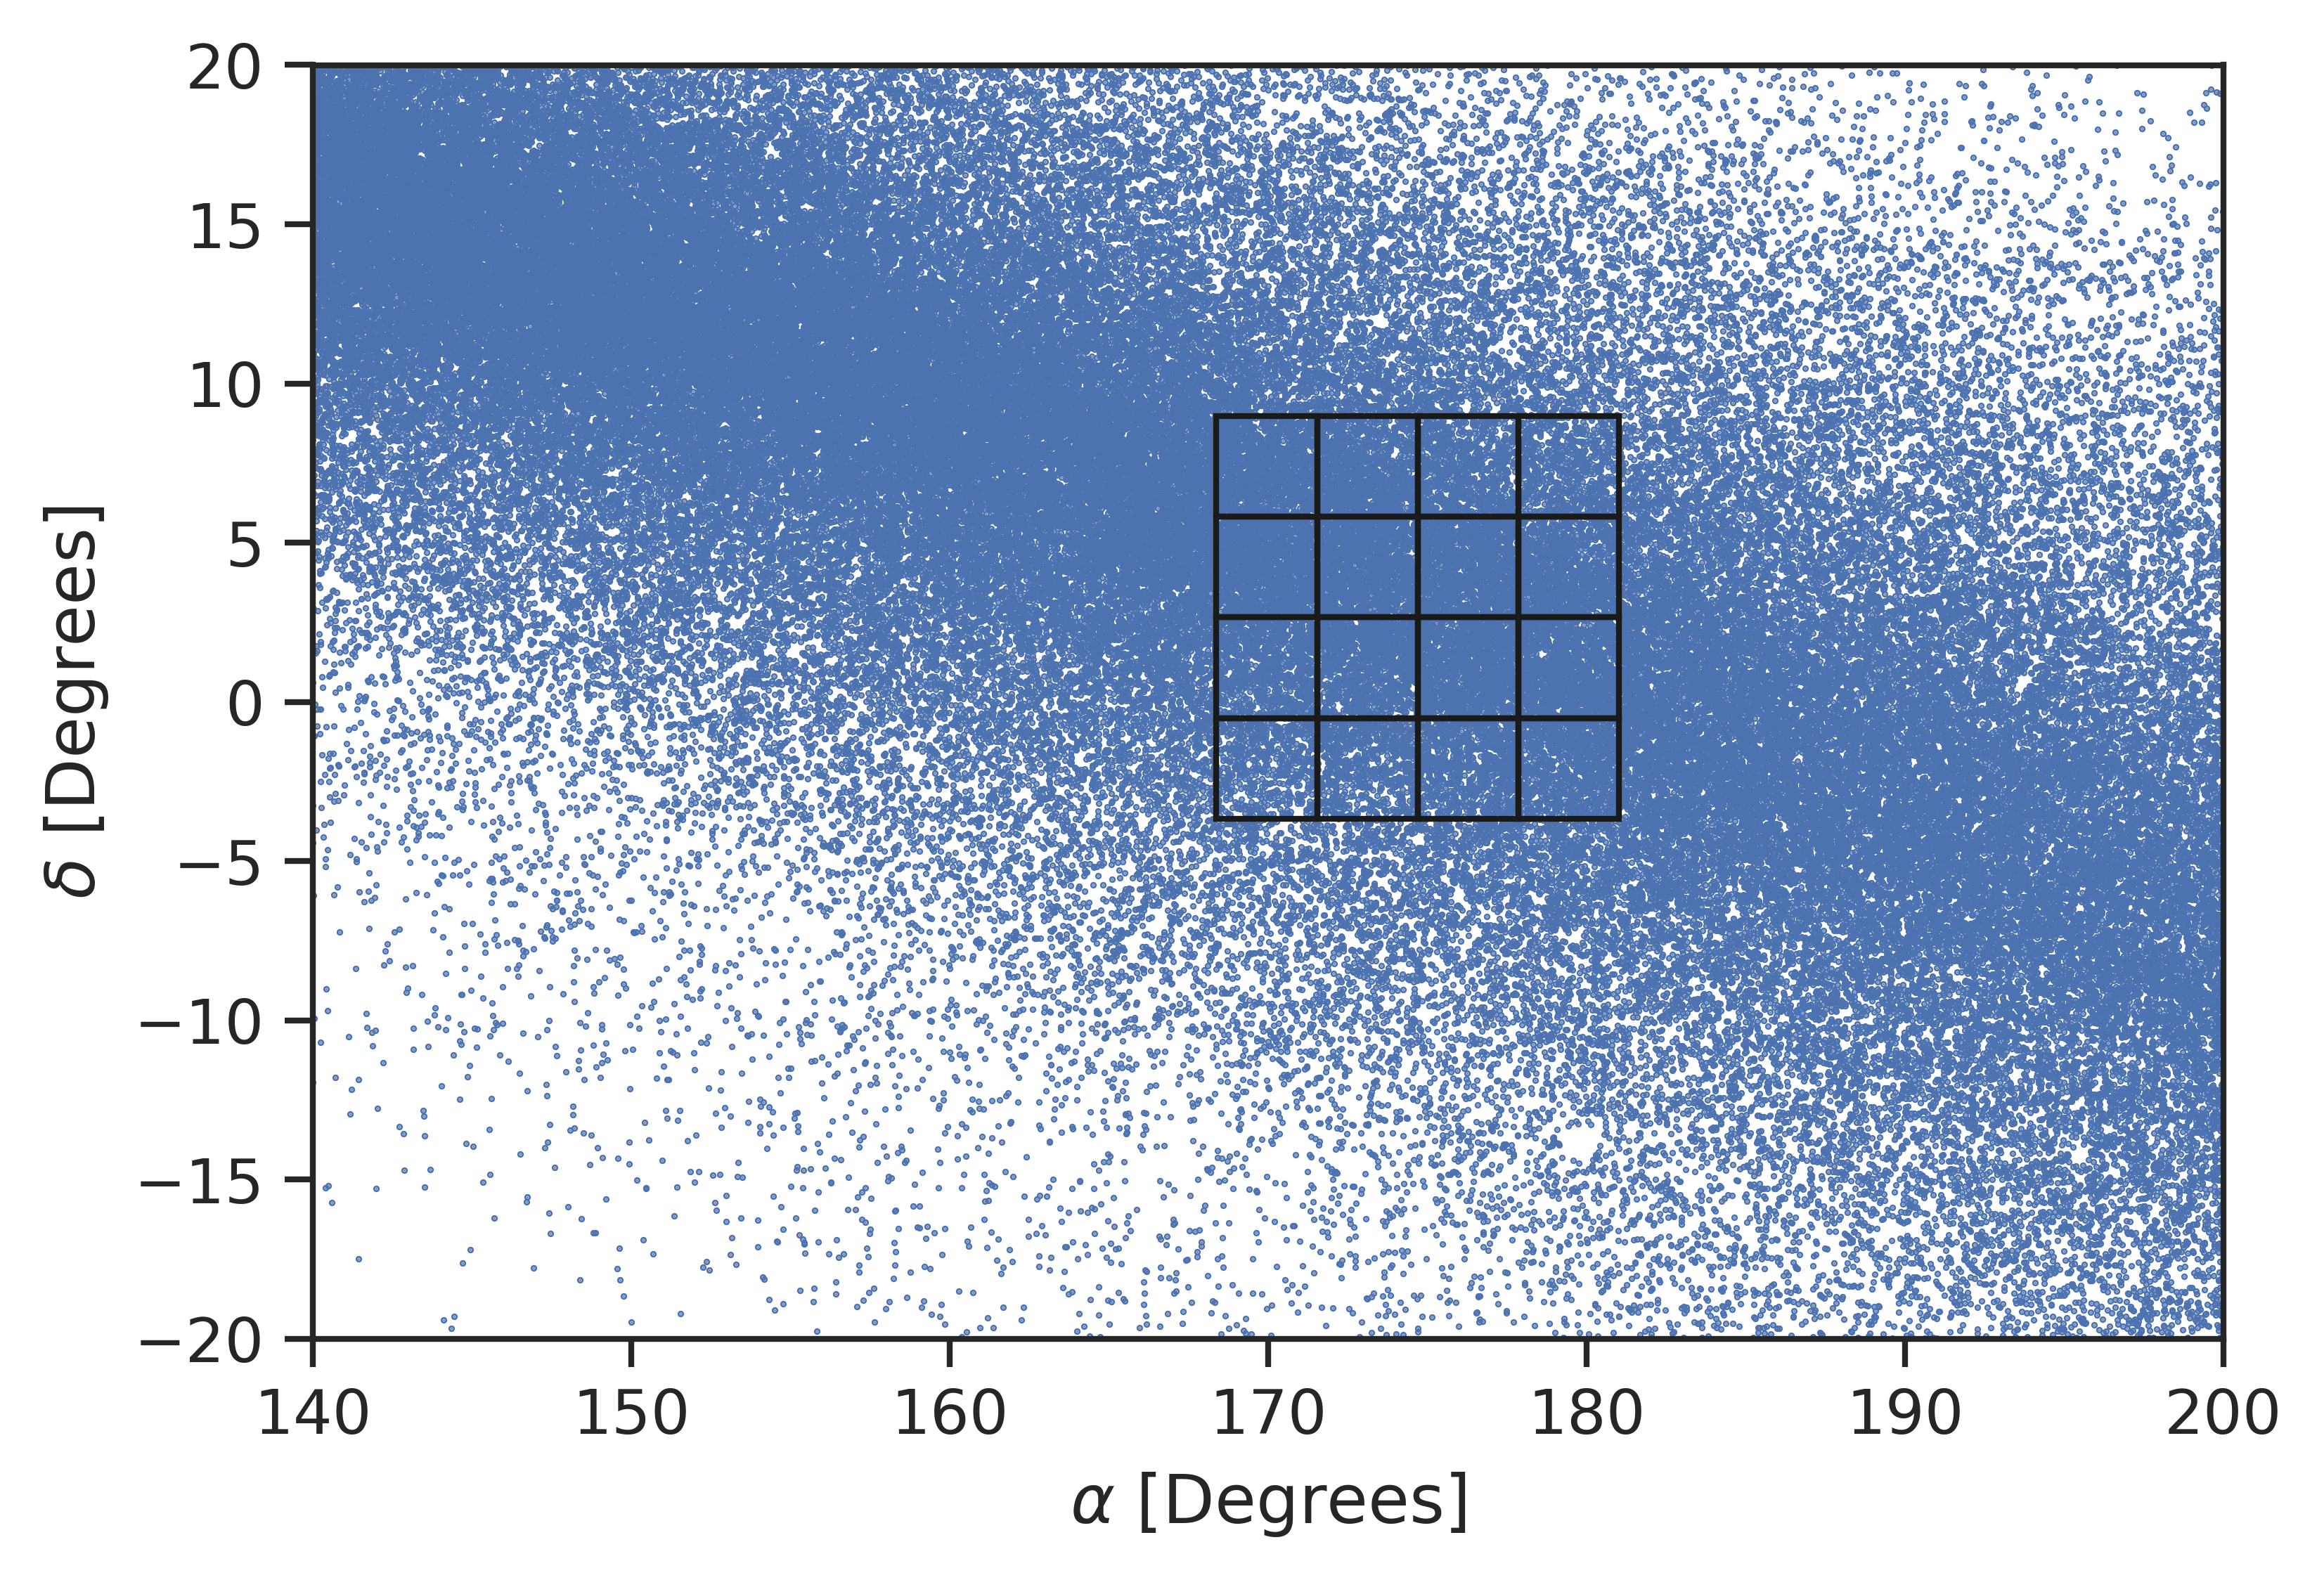

In [9]:
# Plot footprint
fieldArea = 10
xField = np.sqrt(fieldArea)
yField = np.sqrt(fieldArea)

fig, ax = plt.subplots(1, 1, dpi=600)
ax.set_xlabel(r"$\alpha$ [Degrees]")
ax.set_ylabel(r"$\delta$ [Degrees]")
fields = [405, 406, 407, 408, 433, 434, 435, 436, 445, 446, 447, 448, 473, 474, 475, 476]
for xx, yy in zip(survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin(fields))]["fieldRA_deg"].values, 
                  survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin(fields))]["fieldDec_deg"].values):
    ax.add_patch(patches.Rectangle((xx-xField/2, yy-yField/2), xField, yField, fill=False, lw=1, color="k"))
ax.scatter(observations[(observations["night"] == survey["night"].min()) & (observations["designation"] != "NS")]["RA_deg"].values, 
           observations[(observations["night"] == survey["night"].min()) & (observations["designation"] != "NS")]["Dec_deg"].values,
           s=0.1,
           c="b")
ax.set_aspect("equal")
ax.set_ylim(-20, 20)
ax.set_xlim(140, 200)

## Make Reduced Survey

In [10]:
fields = [405, 406, 407, 408, 433, 434, 435, 436, 445, 446, 447, 448, 473, 474, 475, 476]
observations = observations[observations["fieldId"].isin(fields)]

In [11]:
orbits = orbits[orbits["designation"].isin(observations["designation"].unique())]
orbits.drop_duplicates(subset="designation", inplace=True)

(5.642774417833482, 9.132279844018699)

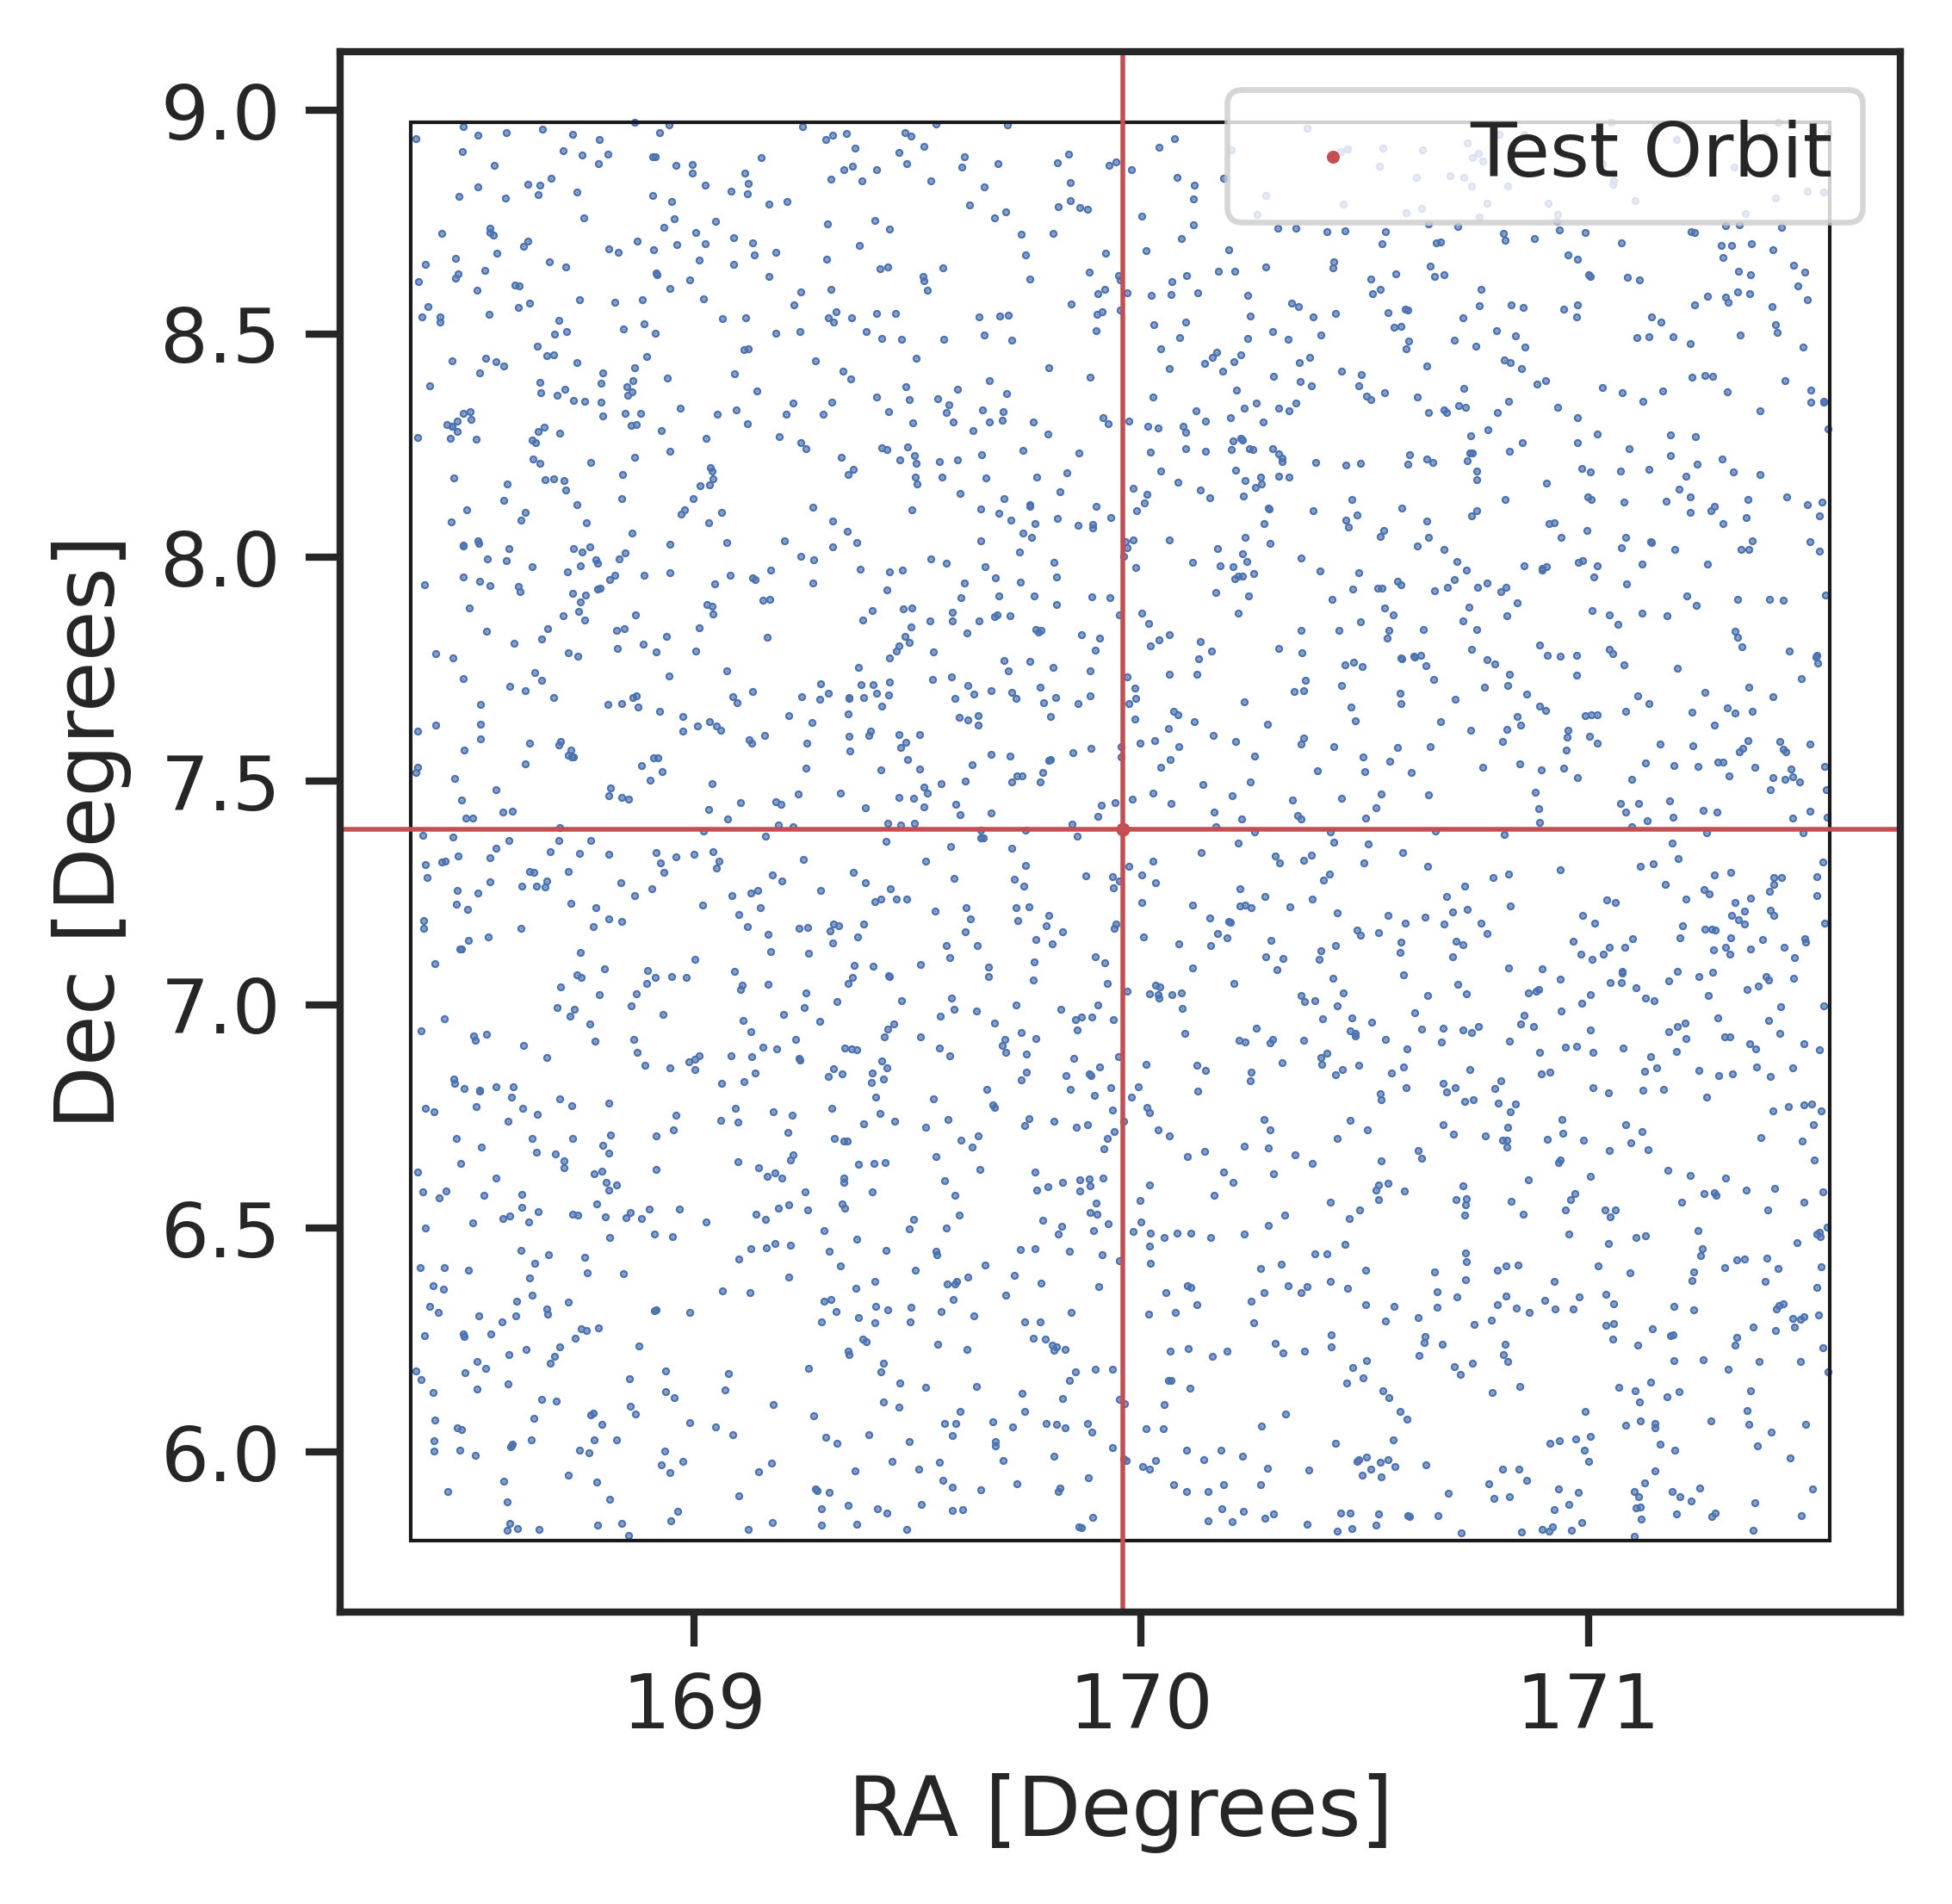

In [12]:
# Plot footprint
fieldArea = 10
xField = np.sqrt(fieldArea)
yField = np.sqrt(fieldArea)

fig, ax = plt.subplots(1, 1, dpi=600)
ax.set_xlabel("RA [Degrees]")
ax.set_ylabel("Dec [Degrees]")
for xx, yy in zip(survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin([405]))]["fieldRA_deg"].values, 
                  survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin([405]))]["fieldDec_deg"].values):
    ax.add_patch(patches.Rectangle((xx-xField/2- 0.01, yy-yField/2 -0.01), xField+0.01, yField+0.01, fill=False, lw=0.5, color="k"))
ax.scatter(observations[(observations["night"] == survey["night"].min()) & (observations["fieldId"].isin([405]))]["RA_deg"].values, 
           observations[(observations["night"] == survey["night"].min()) & (observations["fieldId"].isin([405]))]["Dec_deg"].values,
           s=0.1,
           c="b")
ax.scatter(survey[survey["fieldId"].isin([405])]["fieldRA_deg"].values, survey[survey["fieldId"].isin([405])]["fieldDec_deg"].values, s=1, c="r", 
           label="Test Orbit")
ax.legend()
ax.set_aspect("equal")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.hlines(survey[survey["fieldId"].isin([405])]["fieldDec_deg"].values, *xlim, lw=0.5, color="r")
ax.vlines(survey[survey["fieldId"].isin([405])]["fieldRA_deg"].values, *ylim, lw=0.5, color="r")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [13]:
observations.loc[observations["designation"] == "NS", "designation"] = ["u{:08d}".format(i) for i in range(len(observations[observations["designation"] == "NS"]))]
observations["code"] = "I11"

In [14]:
from thor import preprocessObservations

column_mapping = {
    "obs_id" : "obsId",
    "mjd" : "exp_mjd",
    "RA_deg" : "RA_deg",
    "Dec_deg" : "Dec_deg",
    "RA_sigma_deg" : None,
    "Dec_sigma_deg" : None,
    "observatory_code" : "code",
    "obj_id" : "designation",
}   
mjd_scale = "utc"
astrometric_errors = {
    "I11" : [
        0.1/3600, 
        0.1/3600
    ]
}

preprocessed_observations, preprocessed_associations = preprocessObservations(
    observations,
    column_mapping,
    mjd_scale=mjd_scale,
    astrometric_errors=astrometric_errors
)

analysis_observations = preprocessed_observations.merge(preprocessed_associations, on="obs_id")

preprocessed_observations.to_csv(
    "/mnt/data/projects/thor/thor_data/msst_4x4/preprocessed_observations.csv",
    index=False
)
preprocessed_associations.to_csv(
    "/mnt/data/projects/thor/thor_data/msst_4x4/preprocessed_associations.csv",
    index=False
)

/home/moeyensj/projects/thor/thor/thor/data_processing.py:146: UserWarning:

No astrometric error columns defined in the column_mapping dictionary.
Using 'astrometric_errors' parameter to assign errors...


/home/moeyensj/projects/thor/thor/thor/data_processing.py:256: UserWarning:

Observation IDs should be of type string, converting...

/home/moeyensj/projects/thor/thor/thor/data_processing.py:265: UserWarning:

Object IDs should be of type string, converting...



In [15]:
from difi import analyzeObservations

column_mapping = {
    "obs_id" : "obs_id",
    "truth" : "obj_id",
    "linkage_id" : "orbit_id"
}

all_truths_survey, findable_observations, summary_survey = analyzeObservations(
    analysis_observations,
    metric="min_obs",
    min_obs=5,
    column_mapping=column_mapping
)

In [16]:
summary_survey

class  num_members  num_obs  findable
0   All       136559   251198     18332

In [17]:
orbits

designation      H     G epoch_pf_TT  meanAnom_deg  argPeri_deg  \
32           00033   8.55  0.33       K183N     261.32809    338.15623   
38           00039   6.00  0.15       K183N     216.69404    208.48159   
141          00142  10.27  0.15       K183N     298.02758    292.13151   
149          00150   8.23  0.15       K183N     251.47552    152.80273   
170          00171   8.31  0.15       K183N     118.53497     56.22102   
...            ...    ...   ...         ...           ...          ...   
758351     K18F09P  18.10  0.15       K1833     266.14541    277.92939   
758355     K18F10B  18.20  0.15       K1833     269.87354    163.95690   
758360     K18F10W  17.30  0.15       K1833     223.11373    199.93964   
758394     K18F18B  18.80  0.15       K183N       8.77896    119.34931   
758506     T3S3411  17.50  0.15       J77AO     336.76277     31.99541   

        ascNode_deg     i_deg         e  n_deg_p_day  ...  numObs numOppos  \
32          8.59509   1.85668  0.332364     0.202070  ...  2391.0     64.0   
38        157.07162  10.36984  0.112095     0.213626  ...  5390.0     87.0   
141       291.24786   2.23846  0.134862     0.262104  ...  2411.0     48.0   
149       206.15087   2.20122  0.123430     0.190922  ...  2443.0     59.0   
170       100.47866   2.54679  0.132461     0.178088  ...  2317.0     62.0   
...             ...       ...       ...          ...  ...     ...      ...   
758351     11.78184   5.61884  0.183469     0.240462  ...    11.0      1.0   
758355    129.51677   3.60233  0.251227     0.247192  ...    11.0      1.0   
758360    128.11657   4.47142  0.226620     0.245393  ...    14.0      1.0   
758394     52.69858   4.86867  0.185574     0.235923  ...    19.0      1.0   
758506     23.87322   4.79089  0.164683     0.252066  ...     8.0      1.0   

           obsArc  rmsResid_arcsec  coarsePerturbers precisePerturbers  \
32      1856-2018             0.50               M-v               38h   
38      1856-2018             0.54               M-v               38h   
141     1898-2018             0.46               M-v               38h   
149     1899-2018             0.47               M-v               38h   
170     1894-2018             0.45               M-v               38h   
...           ...              ...               ...               ...   
758351     2 days             0.14              None              None   
758355     2 days             0.14              None              None   
758360     9 days             0.17              None              None   
758394    34 days             0.21              None              None   
758506    10 days              NaN              None              None   

        compName flags readableDesignation lastObsInOrbitSolution  
32      MPCLINUX  0000     (33) Polyhymnia             20180327.0  
38      MPCLINUX  0000       (39) Laetitia             20180319.0  
141     MPCLINUX  0000        (142) Polana             20180329.0  
149     MPCLINUX  0000          (150) Nuwa             20180328.0  
170     MPCLINUX  0000       (171) Ophelia             20180316.0  
...          ...   ...                 ...                    ...  
758351      MPCW  0000            2018 FP9             20180319.0  
758355      MPCW  0000           2018 FB10             20180319.0  
758360      MPCW  0000           2018 FW10             20180319.0  
758394    MPCMEL  0000           2018 FB18             20180413.0  
758506  Bardwell  2000            3411 T-3             19771017.0  

[24481 rows x 23 columns]

In [18]:
from thor import findAverageOrbits

average_orbits_hun1 = findAverageOrbits(
    observations[observations["night"] == observations["night"].min()],
    orbits[(orbits["a_au"] < 2.06) & (orbits["a_au"] >= 1.7) & (orbits["e"] <= 0.1)],
    element_type="keplerian",
    d_values=[1.7, 2.06]
)
average_orbits_hun2 = findAverageOrbits(
    observations[observations["night"] == observations["night"].min()],
    orbits[(orbits["a_au"] < 2.06) & (orbits["a_au"] >= 1.7) & (orbits["e"] > 0.1) & (orbits["e"] <= 0.2)],
    element_type="keplerian",
    d_values=[1.7, 2.06]
)
average_orbits_hun3 = findAverageOrbits(
    observations[observations["night"] == observations["night"].min()],
    orbits[(orbits["a_au"] < 2.06) & (orbits["a_au"] >= 1.7) & (orbits["e"] > 0.2) & (orbits["e"] <= 0.4) ],
    element_type="keplerian",
    d_values=[1.7, 2.06]
)
average_orbits = findAverageOrbits(
    observations[observations["night"] == observations["night"].min()],
    orbits[orbits["e"] < 0.5],
    element_type="keplerian",
    d_values=[2.06, 2.5, 2.82, 2.95, 3.27, 5.0, 50]
)
average_orbits = pd.concat([average_orbits_hun1, average_orbits_hun2, average_orbits_hun3, average_orbits])
average_orbits.sort_values(by="a_au", inplace=True)
average_orbits["orbit_id"] = np.arange(1, len(average_orbits) + 1)
average_orbits.reset_index(inplace=True, drop=True)

In [19]:
average_orbits

orbit_id       exp_mjd  HEclObj_X_au  HEclObj_Y_au  HEclObj_Z_au  \
0         1  59740.247222     -1.822403     -0.861798     -0.010464   
1         2  59740.246528     -2.335982     -0.790806      0.029560   
2         3  59740.238194     -1.960220     -0.821299     -0.072469   
3         4  59740.237500     -2.045316     -0.862221     -0.148130   
4         5  59740.220139     -2.981904     -0.590010     -0.220128   
5         6  59740.218056     -3.123217     -0.291872      0.158942   
6         7  59740.246528     -3.410219     -0.757158      0.196942   
7         8  59740.239583     -4.795452     -0.347436      0.343767   
8         9  59740.218056    -42.021666      8.884724      1.669747   

   HEclObj_dX/dt_au_p_day  HEclObj_dY/dt_au_p_day  HEclObj_dZ/dt_au_p_day  \
0                0.005203               -0.009630               -0.004288   
1                0.001472               -0.008939                0.001756   
2                0.003461               -0.009784                0.003993   
3                0.002745               -0.011507                0.000024   
4                0.001167               -0.009082                0.000384   
5                0.001035               -0.009255                0.000171   
6                0.001374               -0.008503                0.000890   
7                0.000900               -0.006856               -0.000111   
8               -0.000675               -0.002570                0.000098   

       RA_deg   Dec_deg       r_au       a_au     i_deg         e designation  
0  175.508384  1.543574   2.015926   1.904373  21.43531  0.075697       n0358  
1  175.272844  2.901701   2.466386   1.911554  11.02403  0.328983     K10T54J  
2  173.870056  0.105118   2.126557   1.913353  21.24912  0.118536     K17H05D  
3  174.377742 -2.535709   2.224564   2.346804   3.89117  0.171452       79151  
4  170.619627 -0.815541   3.047675   2.685105   4.93152  0.149272       T8186  
5  168.738412  8.117686   3.140849   2.910515   3.10391  0.080989       18043  
6  177.481409  4.897460   3.498810   3.142568   6.56006  0.129820     K14WS3Y  
7  174.304840  7.069604   4.820295   3.947871   4.14559  0.228410     K10O54W  
8  168.642483  7.296200  42.983099  44.176902   3.00060  0.056553     K14Wo9A

In [20]:
from astropy.time import Time
from thor.orbits import Orbits

test_orbits = Orbits(
    average_orbits[['HEclObj_X_au', 'HEclObj_Y_au', 'HEclObj_Z_au', 'HEclObj_dX/dt_au_p_day', 'HEclObj_dY/dt_au_p_day', 'HEclObj_dZ/dt_au_p_day']].values,
    Time(average_orbits["exp_mjd"].values, scale="utc", format="mjd"),
    ids=average_orbits["designation"].values
)

In [21]:
import logging
from thor import runTHOR

MIN_OBS = 5
MIN_ARC_LENGTH = 1.0
CONTAMINATION_PERCENTAGE = 20
BACKEND = "PYOORB"
BACKEND_KWARGS = {}
NUM_THREADS = 60

USE_RAY = False
USE_GPU = False

RANGE_SHIFT_CONFIG = {
    "cell_area" : 1000, 
    "threads" : NUM_THREADS,
    "backend" : BACKEND,
    "backend_kwargs" : BACKEND_KWARGS,
}

CLUSTER_LINK_CONFIG = {
    "vx_range" : [-0.1, 0.1], 
    "vy_range" : [-0.1, 0.1],
    "vx_bins" : 300, 
    "vy_bins" : 300,
    "vx_values" : None,
    "vy_values" : None,
    "eps" : 0.005,
    "min_samples" : MIN_OBS,
    "min_arc_length" : MIN_ARC_LENGTH,
    "threads" : NUM_THREADS,
}

IOD_CONFIG = {
    "min_obs" : MIN_OBS,
    "min_arc_length" : MIN_ARC_LENGTH,
    "contamination_percentage" : CONTAMINATION_PERCENTAGE,
    "rchi2_threshold" : 100000,
    "observation_selection_method" : "combinations",
    "iterate" : False,
    "light_time" : True,
    "linkage_id_col" : "cluster_id",
    "identify_subsets" : False,
    "threads" : NUM_THREADS,
    "backend" : BACKEND,
    "backend_kwargs" : BACKEND_KWARGS,
}

OD_CONFIG = {
    "min_obs" : MIN_OBS,
    "min_arc_length" : MIN_ARC_LENGTH,
    "contamination_percentage" : CONTAMINATION_PERCENTAGE,
    "rchi2_threshold" : 10,
    "delta" : 1e-6,
    "max_iter" : 10,
    "method" : "central",
    "fit_epoch" : False,
    "test_orbit" : None,
    "threads" : NUM_THREADS,
    "backend" : BACKEND,
    "backend_kwargs" : BACKEND_KWARGS,
}

ODP_CONFIG = {
    "min_obs" : MIN_OBS,
    "min_arc_length" : MIN_ARC_LENGTH,
    "contamination_percentage" : 0.0,
    "rchi2_threshold" : 10,
    "eps" : 1/3600, 
    "delta" : 1e-8,
    "max_iter" : 5,
    "method" : "central",
    "fit_epoch" : False,
    "orbits_chunk_size" : 1000,
    "observations_chunk_size" : 100000,
    "threads" : NUM_THREADS,
    "backend" : BACKEND,
    "backend_kwargs" : BACKEND_KWARGS,
}

In [22]:
test_orbits_, recovered_orbits, recovered_orbit_members = runTHOR(
    preprocessed_observations, 
    test_orbits,
    range_shift_config=RANGE_SHIFT_CONFIG,
    cluster_link_config=CLUSTER_LINK_CONFIG,
    iod_config=IOD_CONFIG,
    od_config=OD_CONFIG,
    odp_config=ODP_CONFIG,
    out_dir="/mnt/data/projects/thor/thor_results/msst_4x4/v1.1/run_4/",
    if_exists="continue",
    logging_level=logging.INFO
)

18:45:33.921 [INFO] thor - Processing orbit 00000000 (1/9)...
18:45:33.948 [INFO] thor - Running range and shift...
18:45:33.950 [INFO] thor - Assuming r = [-1.82240293 -0.86179757 -0.01046406] au
18:45:33.951 [INFO] thor - Assuming v = [ 0.00520301 -0.00962981 -0.00428769] au per day
18:45:41.302 [INFO] thor - Found 251198 observations.
18:45:41.304 [INFO] thor - Range and shift completed in 7.354 seconds.
18:45:49.467 [INFO] thor - Running velocity space clustering...
18:45:49.470 [INFO] thor - Max sample distance: 0.005
18:45:49.470 [INFO] thor - Minimum samples: 5
19:35:05.230 [INFO] thor - Clustering completed in 2955.763 seconds.
19:35:05.232 [INFO] thor - Restructuring clusters...
19:35:08.943 [INFO] thor - Restructuring completed in 3.710 seconds.
19:35:08.944 [INFO] thor - Found 22747 clusters.
19:35:08.945 [INFO] thor - Clustering and restructuring completed in 2959.476 seconds.
19:35:09.247 [INFO] thor.orbits.iod - Running initial orbit determination...
19:37:05.560 [INFO] t

In [23]:
recovered_orbits

test_orbit_id                          orbit_id         epoch  \
0          00000000  02041ec1c02745ea9378ca1cec786587  59746.237078   
1          00000000  02cf720acb7c4f8aa818ba4c9aec708b  59744.228543   
2          00000000  047fcd900723419f8f194a45e28780c2  59744.256982   
3          00000000  053f7eb0f1754d7dbf94c9fcd34f9076  59748.254148   
4          00000000  05c22eab3f46433c8e3e9933087f7a42  59746.236646   
...             ...                               ...           ...   
16724      00000008  eb5c9369f4464853970bbb93ad450910  59745.967904   
16725      00000008  f3c20d46c0b44684bb664b0a00f29117  59745.995628   
16726      00000008  f404f3e080e7421d9142f75a7f36fde1  59746.019185   
16727      00000008  f8b92636a23545b08c9d0d55d9b416b2  59745.986134   
16728      00000008  fc66e1b1fd094d80b6f9454da551a5aa  59745.955934   

               x         y         z        vx        vy            vz  \
0      -1.856905 -0.863056  0.108544  0.005664 -0.011400 -1.584686e-03   
1      -2.131574 -0.620051  0.148580  0.002951 -0.011738 -1.413113e-03   
2      -1.820950 -0.972931 -0.012347  0.004819 -0.011491 -1.424911e-03   
3      -2.122304 -0.977333 -0.085046  0.006634 -0.008824 -1.090961e-03   
4      -1.937024 -0.830645  0.036089  0.004943 -0.011195 -9.867466e-04   
...          ...       ...       ...       ...       ...           ...   
16724 -33.486547  5.944176  0.208670 -0.029259  0.003226  1.935138e-04   
16725 -41.840986  6.313956  3.069264  0.028388 -0.007880 -2.057940e-03   
16726 -43.040708 -0.597134 -0.458023 -0.008097 -0.002574 -5.323499e-07   
16727 -44.183387  4.874618  1.773668 -0.008507 -0.001415  3.796527e-04   
16728 -44.784622  9.088277  2.319699  0.047609 -0.013554 -2.527519e-03   

                                              covariance          r   r_sigma  \
0      [[5.51671873985249e-06, -4.6399216425086467e-0...   2.050547  0.002362   
1      [[9.919485465213112e-06, -1.9169112928187197e-...   2.224893  0.003216   
2      [[2.2528395145627243e-05, -4.6238901277906e-07...   2.064608  0.004748   
3      [[2.7193096891898424e-05, -4.869124866957746e-...   2.338073  0.005220   
4      [[1.9829747549588583e-05, -1.944166777750868e-...   2.107922  0.004475   
...                                                  ...        ...       ...   
16724  [[0.9441783477189322, -0.19665597825974562, -0...  34.010669  0.992560   
16725  [[0.3181522705351343, -0.05581869980397543, -0...  42.425871  0.574165   
16726  [[0.029879310978991932, -0.0002863743818536382...  43.047287  0.172874   
16727  [[0.5312347622066524, -0.07091226580401094, -0...  44.486846  0.735908   
16728  [[0.8428880756337132, -0.1904673830569134, -0....  45.756312  0.942443   

              v   v_sigma  arc_length  num_obs num_params num_iterations  \
0      0.012828  0.000016   12.020833        7          6              2   
1      0.012186  0.000021   12.021528        7          6              2   
2      0.012542  0.000029   10.018056        6          6              2   
3      0.011093  0.000051   12.017361        7          6              2   
4      0.012277  0.000028   12.008333        7          6              5   
...         ...       ...         ...      ...        ...            ...   
16724  0.029437  0.029452   12.000000        7          6              2   
16725  0.029533  0.018708   12.000000        7          6              5   
16726  0.008496  0.001158   12.000000        7          6              2   
16727  0.008632  0.032570   12.000000        7          6              2   
16728  0.049565  0.027248   12.000000        7          6              2   

           chi2     rchi2  
0      5.676054  0.709507  
1      7.035830  0.879479  
2      4.477129  0.746188  
3      2.741148  0.342644  
4      7.417780  0.927223  
...         ...       ...  
16724  4.866333  0.608292  
16725  5.103937  0.637992  
16726  9.402527  1.175316  
16727  6.828879  0.853610  
16728  9.834505  1.229313  

[16729 rows x 20 columns]